<a href="https://colab.research.google.com/github/EjbejaranosAI/dl-medical-analysis-images/blob/main/NeurIPS_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NEURIPS 2022 CHALLENGE

  Author: Edison Bejarano

1. Transform image sets from multi formats to png format
2. Dataloader 
3. Architectures design
4. Training
5. Results




Some details of the challenge are here:
- https://pitch.com/public/afc6b0b0-5ffb-4472-955b-823aa17978aa
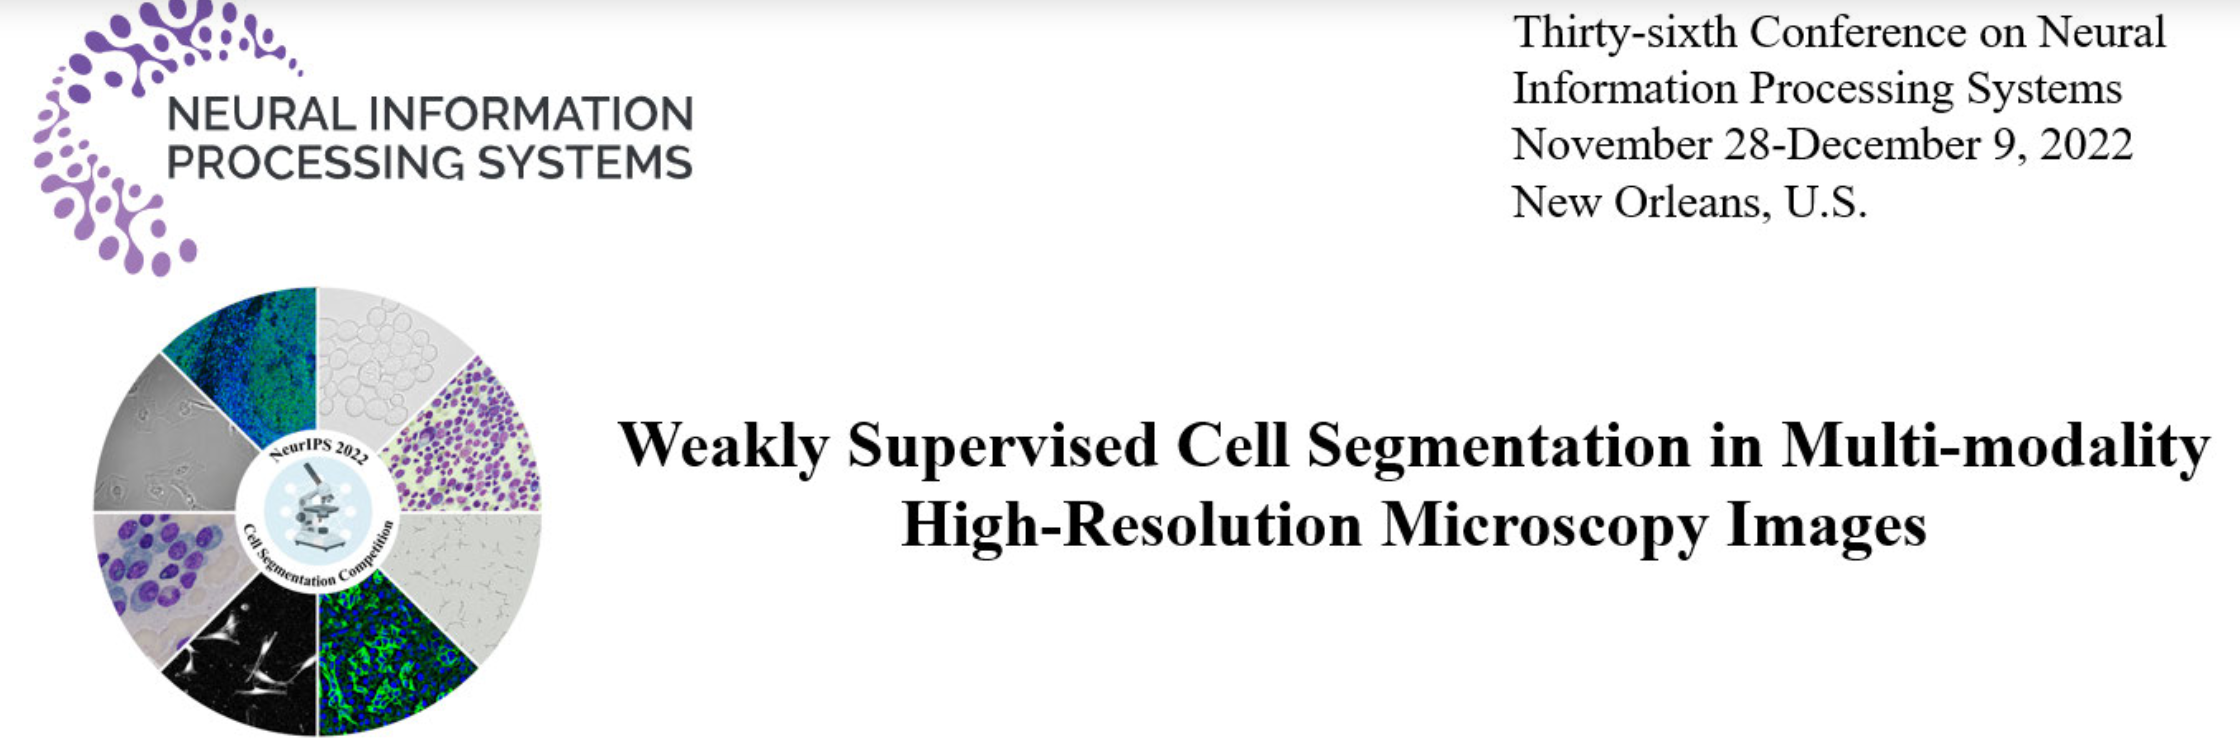


- Weakly supervised cell segmentation refers to the process of automatically identifying and separating individual cells in microscopy images using only partial or noisy annotations. This can be challenging because cells can have complex shapes and vary significantly in appearance, especially in multi-modality images that contain multiple types of information about the cells.

- There are several approaches that can be used for weakly supervised cell segmentation in multi-modality microscopy images. One approach is to use machine learning techniques such as convolutional neural networks (CNNs) to learn to segment cells from the annotated data. These CNNs can be trained to recognize the characteristic features of cells in the images and use this information to segment the cells.

## 1. Transform image sets from multi formats to png format

Copy the link that contain the data

In [ ]:
#!cp https://drive.google.com/drive/folders/1NmDiOuLn58ZT2MMO1z9Aj_IYcVzrWqim?usp=share_link .

Copy the preproces script and executed (take care that the direcotory name, contain the same name that the have in the pre_process_3class.py)

In [1]:
#!python3 pre_process_3class.py
# Python Package Index (PyPI)
!pip install -q torchmetrics

     |████████████████████████████████| 512 kB 4.5 MB/s 


This code preprocesses microscopy images by converting instance labels to three class labels:

- 0: background
- 1: interior
- 2: boundary

It does this by first reading in an image and its corresponding ground truth image. Then it creates an interior-edge map by:

Identifying the boundaries of the instance labels using segmentation.find_boundaries
Dilating the boundaries using morphology.binary_dilation
Identifying the interior region as the region that is not a boundary and has a positive instance label
Removing small objects from the interior region using morphology.remove_small_objects
Finally, the code normalizes the image data, saves the preprocessed images and labels to the specified output path, and displays the original image, ground truth image, and preprocessed ground truth image using matplotlib.pyplot.imshow.

Read original data and convert from tiff and tif format to png using pre_process_3class.py, that also, prepare the images to have 3 classes in the image segmentation.
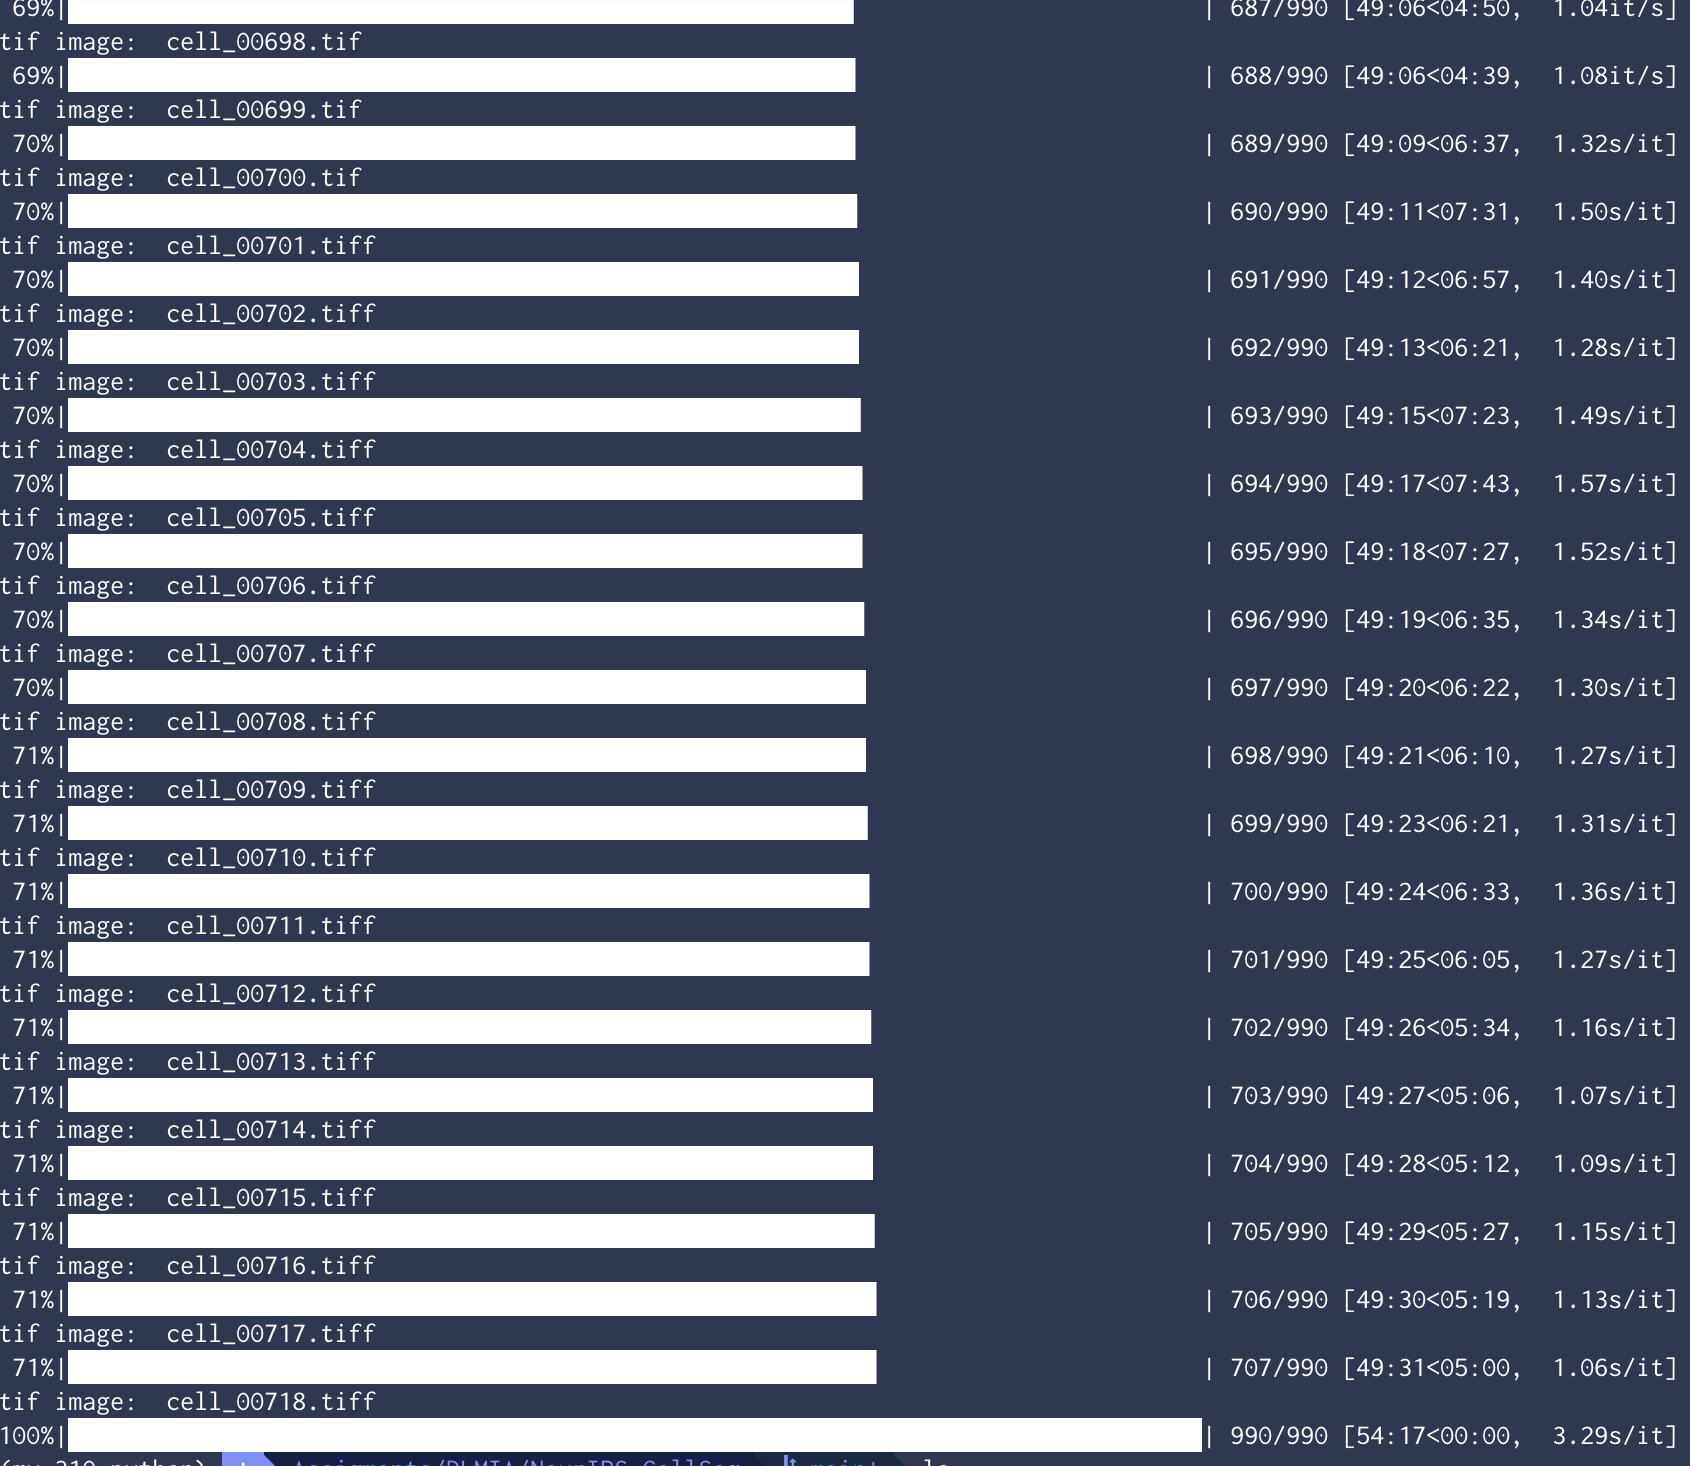




- As it was observed in the transformation of the format in the images, some of then, it was containing corrupted images, with that it was tried to change the way of the transofrmation and, also, read with other libraries, but did not present good results, that is why it was located and them delete it from the original image set.

Finally the data output it is going to foun ot in the following link: 
- https://drive.google.com/drive/folders/1p2zfxXY45PH4gNOFbrD00s9pHKFmgSh_?usp=share_link


## 2. Dataloader

* Import libraries
* Obtaining data
* Helper functions
* Read data and plot examples
* Create a dataloader

### Importing libraries

In [ ]:
#!pip install -U segmentation-models-pytorch albumentations --user 

In [2]:
# Importing libraries
import os
import cv2
import sys
import glob
import torch 
import imageio
import tensorflow
import torch as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import backend as K
from skimage.transform import resize
from skimage.io import imread, imshow

from tensorflow.keras import layers
from pickleshare import print_function
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [43]:
# Checking the gpu available
!nvidia-smi

Tue Jan  3 01:03:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    51W / 400W |  27314MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Obtaining data

In [139]:
#!cp -r /content/drive/MyDrive/Colab_Notebooks/DLMIA/pre_process_3class.py .
#!cp -r /content/drive/MyDrive/Colab_Notebooks/DLMIA/data/train .

In [4]:
# Uncomment to bring the data from the Drive directory 
!cp -r /content/drive/MyDrive/Colab_Notebooks/DLMIA/data/Train_Pre_3class .

Checking the number of images and masks

In [44]:
print("The number of images obtained are: ",len(os.listdir("/content/Train_Pre_3class/images")))
print("The number of labels obtained are: ",len(os.listdir("/content/Train_Pre_3class/labels")))

The number of images obtained are:  990
The number of labels obtained are:  990


### Helpr functions

In [45]:
def get_paths(root_data):
  train_dir = os.listdir(root_data)
  path_image = os.path.join(root_data,train_dir[0])
  path_label = os.path.join(root_data,train_dir[1])

  return path_image, path_label

def get_path_images(root_path):
  path_image, path_label= get_paths(root_path)
  #print(path_image)
  #print(path_label)
  img_full_path = []
  label_full_path = []

  list_img = os.listdir(path_image)
  list_label = os.listdir(path_label)
  #print(list_img[0])
  #print(list_label[0])
  [img_full_path.append(os.path.join(path_image,path_img)) for path_img in list_img]
  #print(img_full_path[0])
  [label_full_path.append(os.path.join(path_label,path_lb)) for path_lb in list_label]
  #print(label_full_path[0])
  print(f"It was founded {len(img_full_path)} paths for images")
  print(f"It was founded {len(label_full_path)} paths for labels")

  return img_full_path, label_full_path



def plot_img_from_path(list_path_1,list_path_2, num_iter):

  img_path_1 = list_path_1[num_iter:num_iter+5]
  img_path_2 = list_path_2[num_iter:num_iter+5]

  # Load the images and store them in a list
  images1 = [plt.imread(path) for path in img_path_1]
  images2 = [plt.imread(path) for path in img_path_2]

  # Create a figure with 10 subplots
  fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 10))
  for ax, image in zip(axs.flat, images1):
      ax.imshow(image)
      ax.set_title(image.shape)
  plt.show()

  fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 10))
  for ax, image in zip(axs.flat, images2):
      ax.imshow(image, cmap='gray')
      ax.set_title(image.shape)
  plt.show()



### Read data and plot examples

In [46]:
root_train = "/content/Train_Pre_3class"
img_path,label_path = get_path_images(root_train)

It was founded 990 paths for images
It was founded 990 paths for labels


In [47]:
import os

input_dir = "/content/Train_Pre_3class/images"
target_dir = "/content/Train_Pre_3class/labels"
img_size = (512, 512)
num_classes = 3
batch_size = 16

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".bmp") or fname.endswith(".png") or fname.endswith(".tif") or fname.endswith(".tiff")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "||", target_path)

Number of samples: 990
/content/Train_Pre_3class/images/cell_00001.png || /content/Train_Pre_3class/labels/cell_00001_label.png
/content/Train_Pre_3class/images/cell_00002.png || /content/Train_Pre_3class/labels/cell_00002_label.png
/content/Train_Pre_3class/images/cell_00003.png || /content/Train_Pre_3class/labels/cell_00003_label.png
/content/Train_Pre_3class/images/cell_00004.png || /content/Train_Pre_3class/labels/cell_00004_label.png
/content/Train_Pre_3class/images/cell_00005.png || /content/Train_Pre_3class/labels/cell_00005_label.png
/content/Train_Pre_3class/images/cell_00006.png || /content/Train_Pre_3class/labels/cell_00006_label.png
/content/Train_Pre_3class/images/cell_00007.png || /content/Train_Pre_3class/labels/cell_00007_label.png
/content/Train_Pre_3class/images/cell_00008.png || /content/Train_Pre_3class/labels/cell_00008_label.png
/content/Train_Pre_3class/images/cell_00009.png || /content/Train_Pre_3class/labels/cell_00009_label.png
/content/Train_Pre_3class/images

### Plot images

Here it was made a plot through the dataset, with the intention of explore the size and characteristics of the images

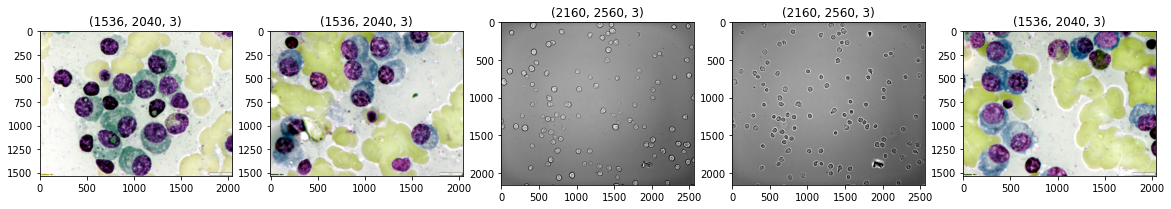

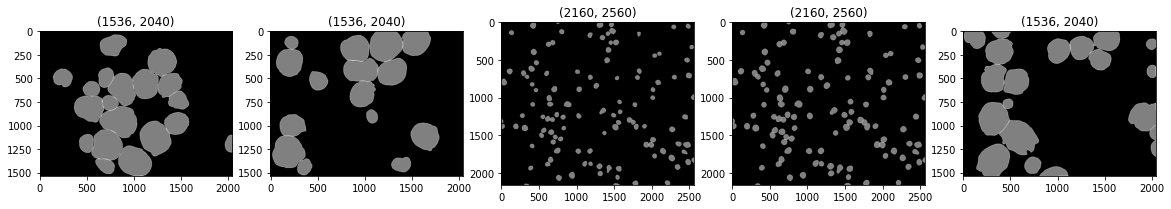

In [ ]:
plot_img_from_path(input_img_paths,target_img_paths,10)

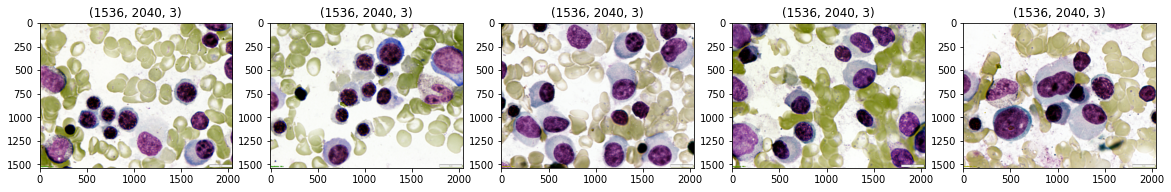

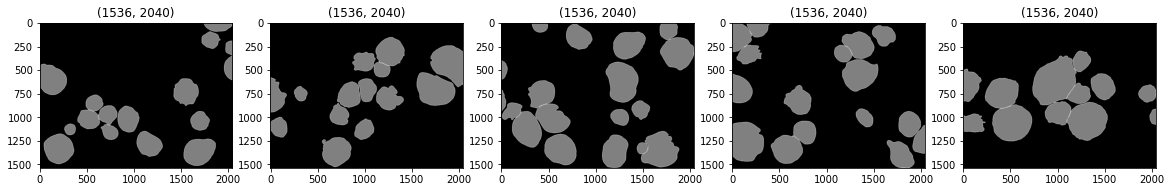

In [ ]:
plot_img_from_path(input_img_paths,target_img_paths,100)

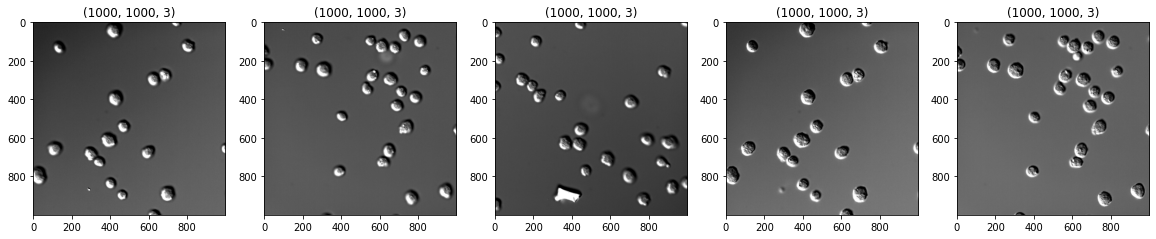

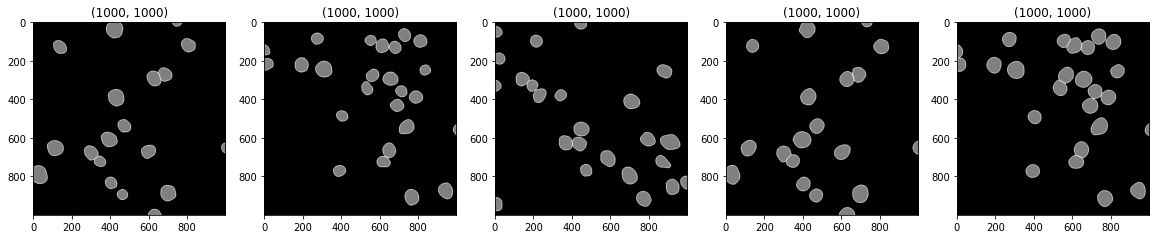

In [ ]:
plot_img_from_path(input_img_paths,target_img_paths,300)

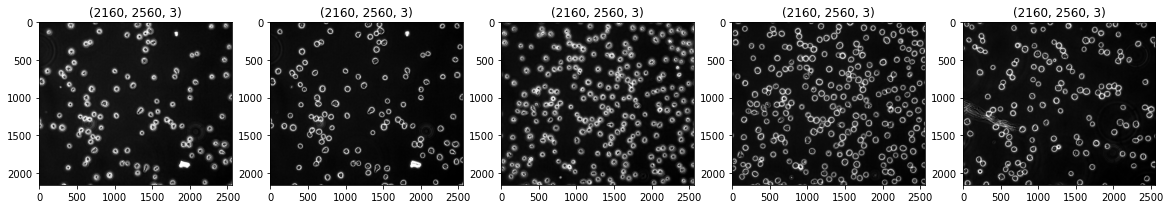

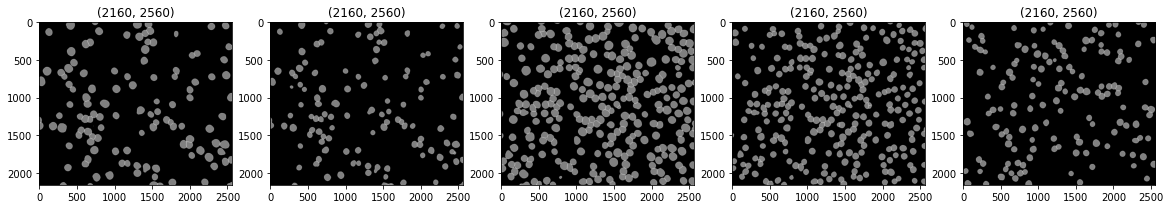

In [ ]:
plot_img_from_path(input_img_paths,target_img_paths,500)

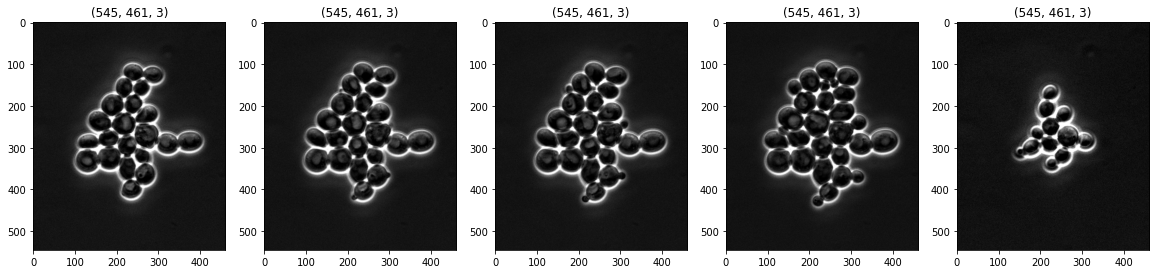

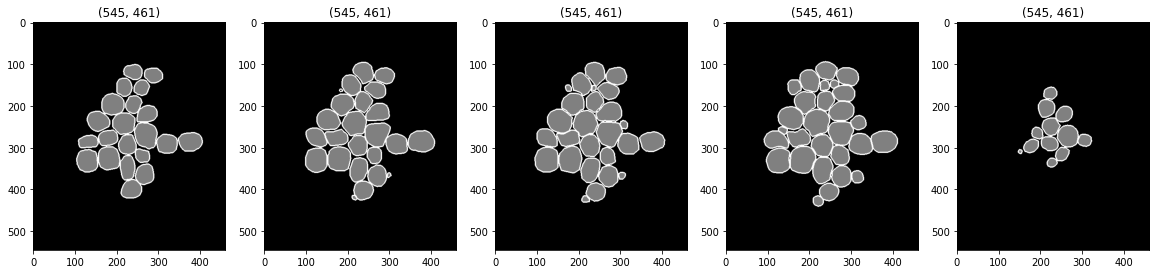

In [ ]:
plot_img_from_path(input_img_paths,target_img_paths,600)

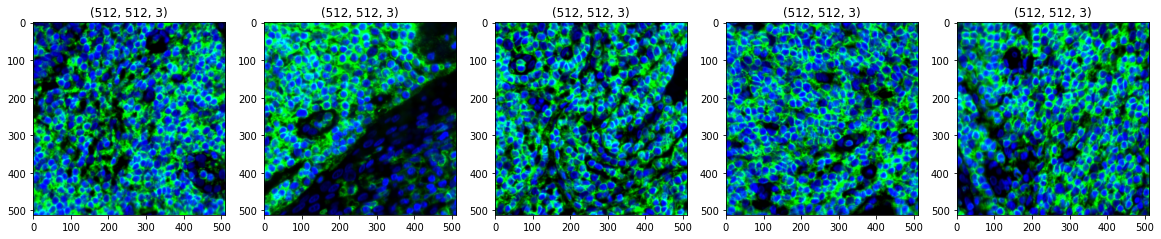

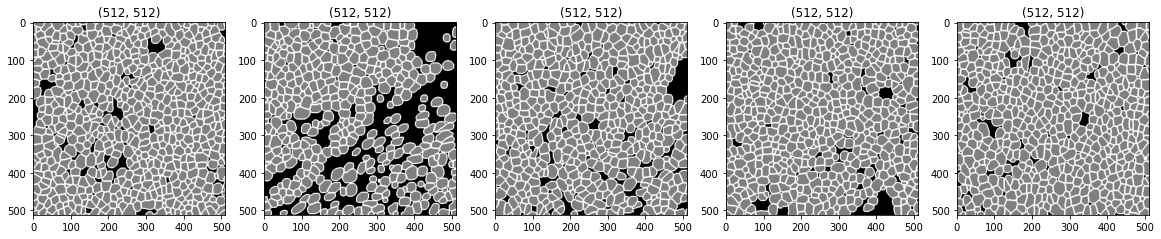

In [ ]:
plot_img_from_path(input_img_paths,target_img_paths,800)

As can be seen, through the plotted data set, it was noticed that the images and labels have different sizes, possibly due to the microscope used to take them. This is why it is recommended to resize the images so that they have something similar between all of them.

### Dataloader created for pythorch pipeline

In [83]:
import torchvision.transforms as transforms
class CellSegmentationDataset(Dataset):
    def __init__(self, image_filenames, label_filenames, transform1=None, transform2=None,augmentation=None):
        self.image_filenames = image_filenames
        self.label_filenames = label_filenames
        self.transform1 = transform1
        self.transform2 = transform2
        self.augmentation = augmentation
        
    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Load image and label
        image = cv2.imread(self.image_filenames[idx])
        label = cv2.imread(self.label_filenames[idx])
        # Apply transforms (if any)
        if self.transform1 and self.transform2:
            image = self.transform1(image)
            #image = transforms.Grayscale(image)
            label = self.transform2(label)
        # Apply augmentation (if any)
        if self.augmentation:
            image, label = self.augmentation(image, label)

        return image, label

image_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.Grayscale(num_output_channels=3),  # Add this line to convert to grayscale
    transforms.ToTensor()
])

label_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.Grayscale(num_output_channels=3),  # Add this line to convert to grayscale
    transforms.ToTensor()
])

The augmentation function takes in an image and a label and applies a series of transformations on them using the transforms module. The transformations include random horizontal and vertical flips, rotations, and affine transforms. These augmentations are applied to both the image and the label.

The image_transform and label_transform variables are instances of the transforms.Compose class. They specify a series of transformations that are applied to the images and labels, respectively.

In [140]:
def augmentation(image, label):
    # Define the augmentation transformations
    image_augmentation = transforms.Compose([
        transforms.ToPILImage(),  # Convert image to PIL Image
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(180),
        transforms.RandomAffine(0, translate=(0.1, 0.1)),
        transforms.ToTensor()
    ])
    label_augmentation = transforms.Compose([
        transforms.ToPILImage(),  # Convert label to PIL Image
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(180),
        transforms.RandomAffine(0, translate=(0.1, 0.1)),
        transforms.ToTensor()
    ])
    # Apply the augmentation transformations
    image = image_augmentation(image)
    label = label_augmentation(label)
    return image, label

In [141]:
from sklearn.model_selection import train_test_split

# Create list of image and label filenames
image_filenames = input_img_paths
label_filenames = target_img_paths


# Split the image and label filenames into training and validation sets
image_train, image_valid, label_train, label_valid = train_test_split(image_filenames, label_filenames, test_size=0.2)
print(f"The number of images to train are: {len(image_train)}")
print(f"The number of labels to train are: {len(label_train)}")
print(f"The number of images to validate are: {len(image_valid)}")
print(f"The number of labels to validate are: {len(label_valid)}")

# Create the training dataset and dataloader
dataset_train = CellSegmentationDataset(image_train, label_train, transform1=image_transform, transform2=label_transform,augmentation= augmentation)
dataloader_train = DataLoader(dataset_train, batch_size=16, shuffle=True,num_workers=2)
# Create the validation dataset and dataloader
dataset_valid = CellSegmentationDataset(image_valid, label_valid, transform1=image_transform, transform2=label_transform)
dataloader_valid = DataLoader(dataset_valid, batch_size=16, shuffle=False,num_workers=2)


The number of images to train are: 792
The number of labels to train are: 792
The number of images to validate are: 198
The number of labels to validate are: 198


##### Checking dataloader iterator for batch and images

In [ ]:
for i, (images, labels) in enumerate(dataloader_train):
    print(f"Batch {i}, min: {images.min():.2f}, max: {images.max():.2f}")

Batch 0, min: 0.00, max: 1.00
Batch 1, min: 0.00, max: 1.00
Batch 2, min: 0.00, max: 1.00
Batch 3, min: 0.00, max: 1.00
Batch 4, min: 0.00, max: 1.00
Batch 5, min: 0.00, max: 1.00
Batch 6, min: 0.00, max: 1.00
Batch 7, min: 0.00, max: 1.00
Batch 8, min: 0.00, max: 1.00
Batch 9, min: 0.00, max: 1.00
Batch 10, min: 0.00, max: 1.00
Batch 11, min: 0.00, max: 1.00
Batch 12, min: 0.00, max: 1.00
Batch 13, min: 0.00, max: 1.00
Batch 14, min: 0.00, max: 1.00
Batch 15, min: 0.00, max: 1.00
Batch 16, min: 0.00, max: 1.00
Batch 17, min: 0.00, max: 1.00
Batch 18, min: 0.00, max: 1.00
Batch 19, min: 0.00, max: 1.00
Batch 20, min: 0.00, max: 1.00
Batch 21, min: 0.00, max: 1.00
Batch 22, min: 0.00, max: 1.00
Batch 23, min: 0.00, max: 1.00
Batch 24, min: 0.00, max: 1.00
Batch 25, min: 0.00, max: 1.00
Batch 26, min: 0.00, max: 1.00
Batch 27, min: 0.00, max: 1.00
Batch 28, min: 0.00, max: 1.00
Batch 29, min: 0.00, max: 1.00
Batch 30, min: 0.00, max: 1.00
Batch 31, min: 0.00, max: 1.00
Batch 32, min: 0.0

In [ ]:
# Iterate over the DataLoader and print the size of each batch
for i, (images, labels) in enumerate(dataloader):
    print(f"Batch {i}, images: {images.size()}, labels: {labels.size()}")

Batch 0, images: torch.Size([1, 1, 256, 256]), labels: torch.Size([1, 1, 256, 256])
Batch 1, images: torch.Size([1, 1, 256, 256]), labels: torch.Size([1, 1, 256, 256])
Batch 2, images: torch.Size([1, 1, 256, 256]), labels: torch.Size([1, 1, 256, 256])
Batch 3, images: torch.Size([1, 1, 256, 256]), labels: torch.Size([1, 1, 256, 256])
Batch 4, images: torch.Size([1, 1, 256, 256]), labels: torch.Size([1, 1, 256, 256])
Batch 5, images: torch.Size([1, 1, 256, 256]), labels: torch.Size([1, 1, 256, 256])
Batch 6, images: torch.Size([1, 1, 256, 256]), labels: torch.Size([1, 1, 256, 256])
Batch 7, images: torch.Size([1, 1, 256, 256]), labels: torch.Size([1, 1, 256, 256])
Batch 8, images: torch.Size([1, 1, 256, 256]), labels: torch.Size([1, 1, 256, 256])
Batch 9, images: torch.Size([1, 1, 256, 256]), labels: torch.Size([1, 1, 256, 256])
Batch 10, images: torch.Size([1, 1, 256, 256]), labels: torch.Size([1, 1, 256, 256])
Batch 11, images: torch.Size([1, 1, 256, 256]), labels: torch.Size([1, 1, 2

#### Check the tensor size for all the imaages

In [ ]:
import matplotlib.pyplot as plt
# Iterate through data samples
for i, (images, labels) in enumerate(dataloader_train):
    # Print size of each image and label
    for j, (image, label) in enumerate(zip(images, labels)):
        print(f'Image {i*dataloader_train.batch_size+j+1}: {image.size()}, Label {i*dataloader_train.batch_size+j+1}: {label.size()}')
    pass

Image 1: torch.Size([3, 256, 256]), Label 1: torch.Size([3, 256, 256])
Image 2: torch.Size([3, 256, 256]), Label 2: torch.Size([3, 256, 256])
Image 3: torch.Size([3, 256, 256]), Label 3: torch.Size([3, 256, 256])
Image 4: torch.Size([3, 256, 256]), Label 4: torch.Size([3, 256, 256])
Image 5: torch.Size([3, 256, 256]), Label 5: torch.Size([3, 256, 256])
Image 6: torch.Size([3, 256, 256]), Label 6: torch.Size([3, 256, 256])
Image 7: torch.Size([3, 256, 256]), Label 7: torch.Size([3, 256, 256])
Image 8: torch.Size([3, 256, 256]), Label 8: torch.Size([3, 256, 256])
Image 9: torch.Size([3, 256, 256]), Label 9: torch.Size([3, 256, 256])
Image 10: torch.Size([3, 256, 256]), Label 10: torch.Size([3, 256, 256])
Image 11: torch.Size([3, 256, 256]), Label 11: torch.Size([3, 256, 256])
Image 12: torch.Size([3, 256, 256]), Label 12: torch.Size([3, 256, 256])
Image 13: torch.Size([3, 256, 256]), Label 13: torch.Size([3, 256, 256])
Image 14: torch.Size([3, 256, 256]), Label 14: torch.Size([3, 256, 25

#### Checking the size for the labels and images

Image 1: torch.Size([1, 256, 256]), Label 1: torch.Size([3, 256, 256])


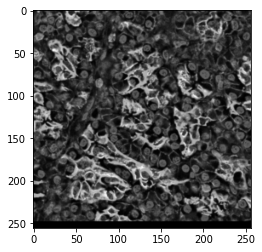

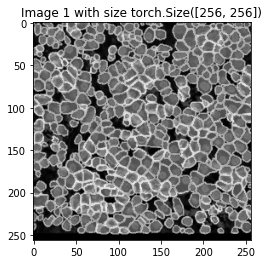

Image 2: torch.Size([1, 256, 256]), Label 2: torch.Size([3, 256, 256])


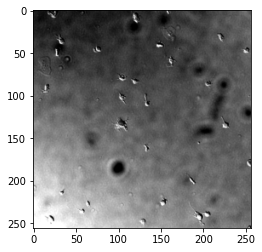

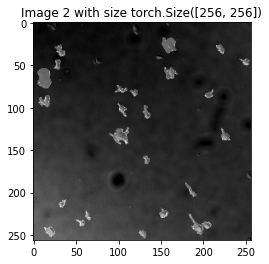

Image 3: torch.Size([1, 256, 256]), Label 3: torch.Size([3, 256, 256])


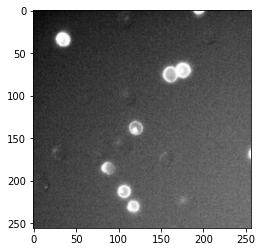

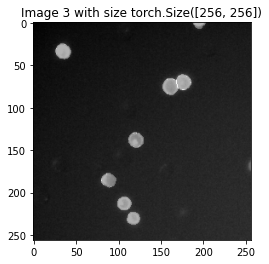

Image 4: torch.Size([1, 256, 256]), Label 4: torch.Size([3, 256, 256])


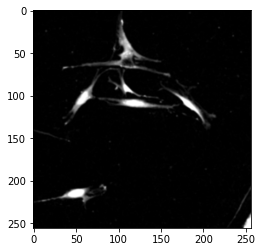

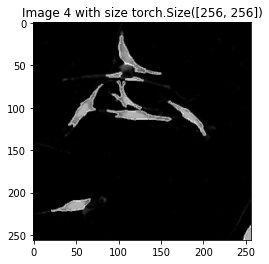

Image 5: torch.Size([1, 256, 256]), Label 5: torch.Size([3, 256, 256])


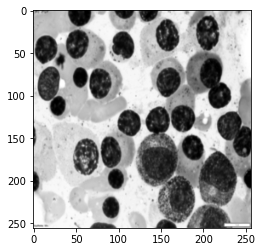

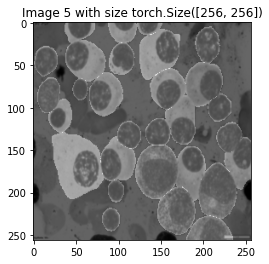

Image 6: torch.Size([1, 256, 256]), Label 6: torch.Size([3, 256, 256])


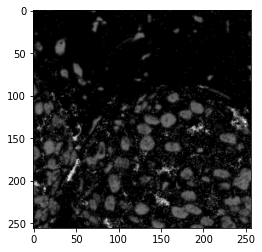

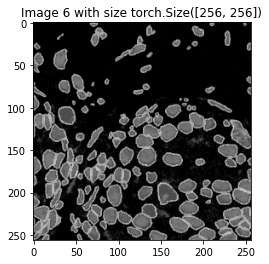

Image 7: torch.Size([1, 256, 256]), Label 7: torch.Size([3, 256, 256])


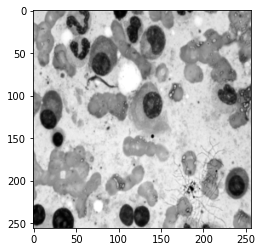

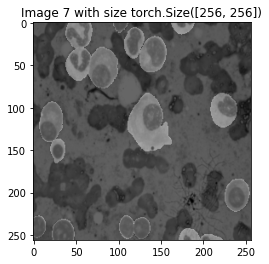

Image 8: torch.Size([1, 256, 256]), Label 8: torch.Size([3, 256, 256])


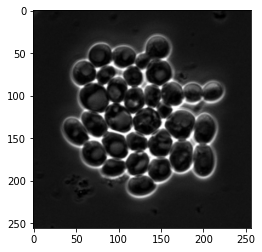

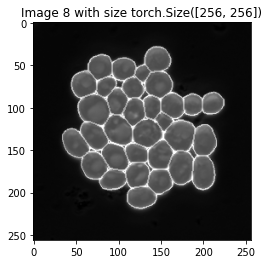

Image 9: torch.Size([1, 256, 256]), Label 9: torch.Size([3, 256, 256])


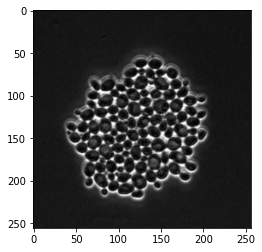

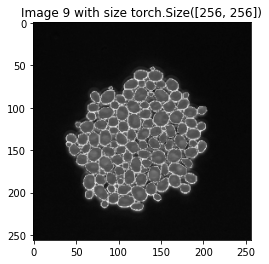

Image 10: torch.Size([1, 256, 256]), Label 10: torch.Size([3, 256, 256])


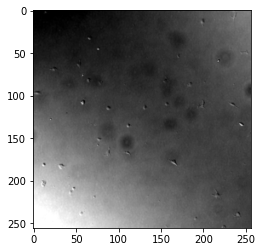

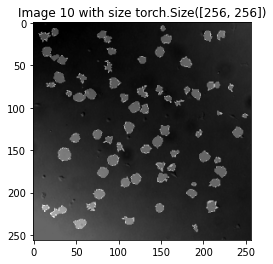

Image 11: torch.Size([1, 256, 256]), Label 11: torch.Size([3, 256, 256])


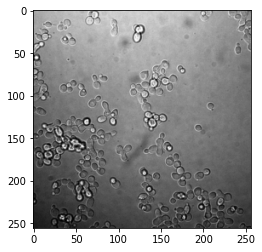

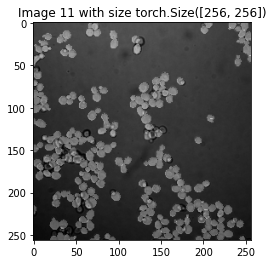

Image 12: torch.Size([1, 256, 256]), Label 12: torch.Size([3, 256, 256])


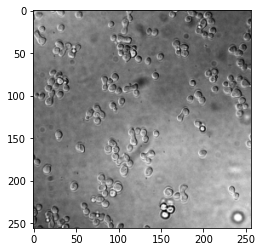

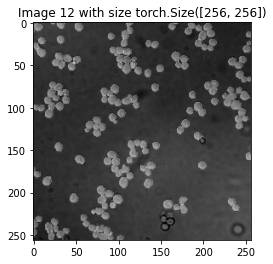

Image 13: torch.Size([1, 256, 256]), Label 13: torch.Size([3, 256, 256])


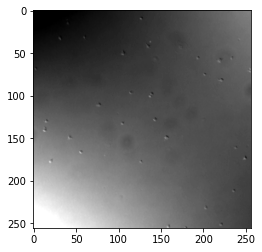

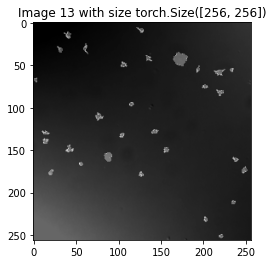

Image 14: torch.Size([1, 256, 256]), Label 14: torch.Size([3, 256, 256])


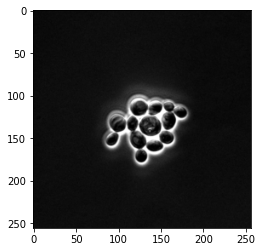

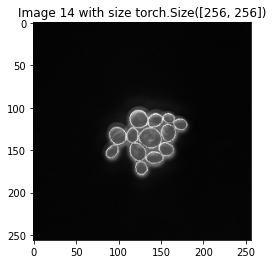

Image 15: torch.Size([1, 256, 256]), Label 15: torch.Size([3, 256, 256])


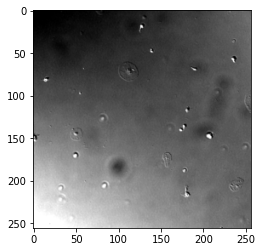

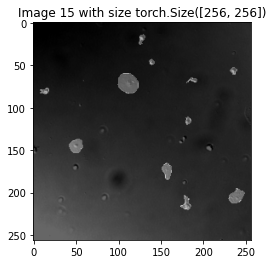

Image 16: torch.Size([1, 256, 256]), Label 16: torch.Size([3, 256, 256])


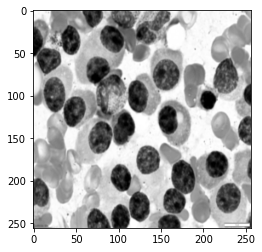

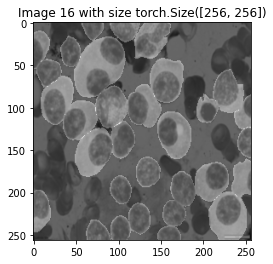

Image 17: torch.Size([1, 256, 256]), Label 17: torch.Size([3, 256, 256])


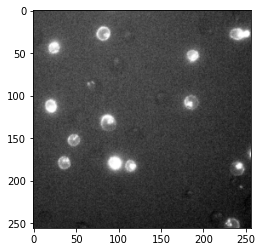

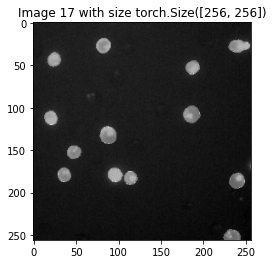

Image 18: torch.Size([1, 256, 256]), Label 18: torch.Size([3, 256, 256])


KeyboardInterrupt: ignored

In [ ]:
# Import matplotlib
import matplotlib.pyplot as plt

# Iterate through data samples
for i, (images, labels) in enumerate(dataloader_train):
    # Print size of each image and label
    for j, (image, label) in enumerate(zip(images, labels)):
        print(f'Image {i*dataloader_train.batch_size+j+1}: {image.size()}, Label {i*dataloader_train.batch_size+j+1}: {label.size()}')
        
        # Select single channel of image
        image = image[0]  # Select first channel
        label = label[0]
        plt.imshow(image, cmap='gray')  # Use grayscale color map
        plt.show()
        # Plot image and label
        plt.imshow(image, cmap='gray')  # Use grayscale color map
        plt.imshow(label, cmap='gray', alpha=0.6)  # Use grayscale color map
        plt.title(f'Image {i*dataloader_train.batch_size+j+1} with size {image.shape}')
        #plt.title(f'Label and Image {i*dataloader_train.batch_size+j+1} with size {label.shape}')
        plt.show()


    # Do something with the data samples
    pass

# Segmentation architecture

###### Utils functions to construct Unet architecture

In [79]:
import torch
import torch.nn.functional as F

def conv3x3_bn(ci, co):
  convolution_layer = torch.nn.Sequential(
      torch.nn.Conv2d(ci,co,3,padding=1),
      torch.nn.BatchNorm2d(co),
      torch.nn.ReLU(inplace=True)
      )
  return convolution_layer


def encoder_conv(ci, co):
  convolution_encoder = torch.nn.Sequential(
      torch.nn.MaxPool2d(2),
      conv3x3_bn(ci, co),
      conv3x3_bn(co, co),
  )

  return convolution_encoder

class transposed_conv(torch.nn.Module):
  def __init__(self, ci, co):
    super(transposed_conv, self).__init__()
    self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
    self.conv1 = conv3x3_bn(ci,co)
    self.conv2 = conv3x3_bn(co,co)

  # Take the ouput of the previous layer and the output of the epoch 
  def forward(self, x1, x2):
    x1 = self.upsample(x1)
    diffX = x2.size()[2] - x1.size()[2]
    diffY = x2.size()[3] - x1.size()[3]
    x1 = F.pad(x1,(diffX, 0, diffY,0))
    # Tensors concatenation
    x = torch.cat([x2,x1], dim=1)
    x = self.conv1(x)
    x = self.conv2(x)
    return x



def get_first_image_and_label(data_loader):
  for batch in data_loader:
    image, label = batch
    return image, label
  return None, None


#### Architecture from scratch

In [85]:
class Unet_from_scratch(torch.nn.Module):
  def __init__(self, n_classes=3, in_chanels=3):
    super().__init__()

    # List with the layers for encoder and decoder with the number of filters
    c = [16, 32, 64, 128, 256, 512]

    # First convolutional layer that recieve the image
    self.conv1 = torch.nn.Sequential(
        conv3x3_bn(in_chanels, c[0]),
        conv3x3_bn(c[0], c[0]),
        )
    # Encoder layers
    self.conv2 = encoder_conv(c[0],c[1])
    self.conv3 = encoder_conv(c[1],c[2])
    self.conv4 = encoder_conv(c[2],c[3])

    # Decoder layers
    self.deconv1 = transposed_conv(c[3],c[2])
    self.deconv2 = transposed_conv(c[2],c[1])
    self.deconv3 = transposed_conv(c[1],c[0])

    #Last layer that create the mask prediction
    self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding=1)
  
  def forward(self,x):
    # Encoder
    x1 = self.conv1(x)
    x2 = self.conv2(x1)
    x3 = self.conv3(x2)
    x = self.conv4(x3)
    # Decoder
    x = self.deconv1(x,x3)
    x = self.deconv2(x,x2)
    x = self.deconv3(x,x1)
    x = self.out(x)

    return x

In [86]:
model = Unet_from_scratch()
output = model(torch.randn((10,3,394,394)))
output.shape

torch.Size([10, 3, 394, 394])

 #### Fit of one image

In [54]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, X, y, epochs=1, lr=3e-4):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  criterion = torch.nn.BCEWithLogitsLoss()
  model.to(device)
  X, y = X.to(device), y.to(device)
  model.train() 
  for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    y_hat = model(X)
    loss = criterion(y_hat, y)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f}")


torch.Size([16, 3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([512, 512])


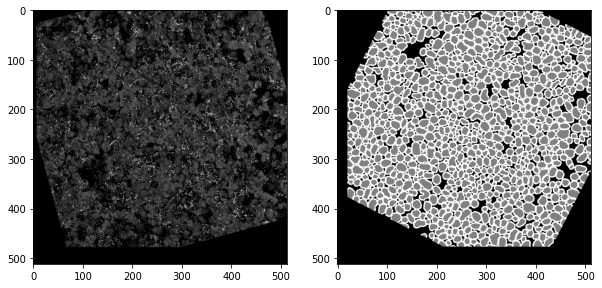

In [126]:
import matplotlib.pyplot as plt

for batch in dataloader_train:
  set_image, set_label = batch

  # Convert the image and label tensors to numpy arrays
  set_numpy_img = set_image.numpy()
  set_numpy_img = set_label.numpy()
  # Move the channel dimension to the last position
  #set_image = np.moveaxis(set_image, 1, -1)

  print(set_label.shape)
  print(set_label[0].shape)
  print(set_label[0][0].shape)
  
  # Select the desired channels from the label data
  image_dl = set_image[0][0]
  label_dl = set_label[0][0]  # select the first 2 channels
  #set_label2 = set_label[0][1]

  # Create a grid of subplots
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))


  axs[0].imshow(image_dl,cmap='gray')
  axs[1].imshow(label_dl,cmap='gray')
  #axs[2].imshow(set_label2,cmap='gray')

  plt.show()

  break


In [127]:
img_to_predict = set_image[0, :, :, :].unsqueeze(dim=0)
mask_to_compare = set_label[0, :, :, :].unsqueeze(dim=0)
print(img_to_predict.shape)
print(mask_to_compare.shape)



torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])


In [89]:
image, label = get_first_image_and_label(dataloader_train)
print(image.shape)
print(label.shape)
#print(dataloader_train)

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


In [128]:
fit(model, img_to_predict, mask_to_compare, epochs=50)

Epoch 1/50 --- loss 0.58296 --- iou 0.00130 
Epoch 2/50 --- loss 0.57021 --- iou 0.00260 
Epoch 3/50 --- loss 0.55931 --- iou 0.00391 
Epoch 4/50 --- loss 0.54944 --- iou 0.00391 
Epoch 5/50 --- loss 0.54011 --- iou 0.00326 
Epoch 6/50 --- loss 0.53111 --- iou 0.00326 
Epoch 7/50 --- loss 0.52229 --- iou 0.00521 
Epoch 8/50 --- loss 0.51380 --- iou 0.00651 
Epoch 9/50 --- loss 0.50545 --- iou 0.00651 
Epoch 10/50 --- loss 0.49723 --- iou 0.00716 
Epoch 11/50 --- loss 0.48916 --- iou 0.00716 
Epoch 12/50 --- loss 0.48126 --- iou 0.00781 
Epoch 13/50 --- loss 0.47349 --- iou 0.00846 
Epoch 14/50 --- loss 0.46580 --- iou 0.01758 
Epoch 15/50 --- loss 0.45821 --- iou 0.03060 
Epoch 16/50 --- loss 0.45073 --- iou 0.05990 
Epoch 17/50 --- loss 0.44341 --- iou 0.11003 
Epoch 18/50 --- loss 0.43619 --- iou 0.17383 
Epoch 19/50 --- loss 0.42910 --- iou 0.25326 
Epoch 20/50 --- loss 0.42210 --- iou 0.34375 
Epoch 21/50 --- loss 0.41518 --- iou 0.42057 
Epoch 22/50 --- loss 0.40833 --- iou 0.4915

The loss metric is working, however, it is necessary to implement a metric that measures how much the referent mask is losing with the image, so IoU is a good option to calculate the intersection between the union of areas. 

In [90]:
import torchmetrics
from torchmetrics import F1Score

f1_score_torch = torchmetrics.F1Score(num_classes=3, task="multiclass")

#f1_score_torch = torchmetrics.F1Score(num_classes=3)

def iou(outputs, labels):
  #print(f"outputs shape: {outputs.shape}")
  #print(f"labels shape: {labels.shape}")

  #Aply sigmoid and convert to binary
  outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
  SMOOTH = 1e-6
  # Batch / Number_of_classes / Height / Weight
  B ,N , H ,W = outputs.shape
  ious = []
  for i in range(N): # Skip bagkground 
    #_out, _labs = outputs[:,i,:,:], labels[:,i:,:,:]
    _out, _labs = outputs[:,i:i+1,:,:], labels[:,i:i+1,:,:]
    intersection = (_out & _labs).float().sum((1,2))
    union = (_out | _labs).float().sum((1,2))
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    ious.append(iou.mean().item())
  return np.mean(ious)

'''It was tested to use the F1 score, but it not was obtained good results to measure in this task'''
def f1_score(outputs, labels):
    # Convert outputs and labels to binary values
    outputs = (outputs > 0.5).float()
    labels = (labels > 0.5).float()
    SMOOTH = 1e-6
    
    # Compute F1 score for each class
    f1_scores = []
    for i in range(outputs.shape[1]):
        true_positives = outputs[:, i].eq(labels[:, i]).sum().item()
        false_positives = outputs[:, i].eq(1).sum().item() - true_positives
        false_negatives = labels[:, i].eq(1).sum().item() - true_positives
        print("False positive: ",false_positives)
        print("False negative: ",false_negatives)
        print("True positive: ",true_positives)
        print(true_positives + false_positives)
        if true_positives + false_positives > 0:
            precision = true_positives / (true_positives + false_positives)
        else:
            precision = 0
        if true_positives + false_negatives > 0:
            recall = true_positives / (true_positives + false_negatives)
        else:
            recall = 0
        if precision + recall > 0:
            f1 = 2 * precision * recall / (precision + recall)
        else:
            f1 = 0
        f1_scores.append(f1)
    
    # Return mean F1 score across all classes
    return sum(f1_scores) / len(f1_scores)

def fit(model, X, y, epochs=1, lr=3e-4):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  criterion = torch.nn.BCEWithLogitsLoss()
  model.to(device)
  X, y = X.to(device), y.to(device)
  model.train() 
  for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    y_hat = model(X)
    loss = criterion(y_hat, y)
    loss.backward()
    optimizer.step()
    ious = iou(y_hat,y)
    #f1_loss = f1_score(y_hat,y)
    #f1_loss_torch_ = f1_score_torch(y_hat, y)
    #print(f"Epoch {epoch}/{epochs} --- loss {loss.item():.5f} --- iou {ious:.5f} --- F1 Score {f1_loss:.5f} --- F1 torch:{f1_loss_torch_:.5f}")
    print(f"Epoch {epoch}/{epochs} --- loss {loss.item():.5f} --- iou {ious:.5f} ")


In [ ]:
fit(model, set_image, set_label, epochs=15)

Epoch 1/15 --- loss 0.25773 --- iou 0.99723 
Epoch 2/15 --- loss 0.25205 --- iou 0.99845 
Epoch 3/15 --- loss 0.24628 --- iou 0.99504 
Epoch 4/15 --- loss 0.24055 --- iou 0.99788 
Epoch 5/15 --- loss 0.23576 --- iou 0.99992 
Epoch 6/15 --- loss 0.23102 --- iou 0.99992 
Epoch 7/15 --- loss 0.22655 --- iou 0.99927 
Epoch 8/15 --- loss 0.22224 --- iou 0.99821 
Epoch 9/15 --- loss 0.21801 --- iou 0.99797 
Epoch 10/15 --- loss 0.21381 --- iou 0.99894 
Epoch 11/15 --- loss 0.20975 --- iou 0.99976 
Epoch 12/15 --- loss 0.20582 --- iou 0.99984 
Epoch 13/15 --- loss 0.20198 --- iou 0.99992 
Epoch 14/15 --- loss 0.19825 --- iou 0.99967 
Epoch 15/15 --- loss 0.19460 --- iou 0.99984 


This code is performing a forward pass through the model and using the output to generate a prediction mask. The model is put in evaluation mode by calling model.eval(), and gradient calculations are turned off for this forward pass by calling with torch.no_grad():. The input tensor img_to_predict is passed through the model and the resulting output tensor is indexed by [0]. The resulting tensor is then passed through the torch.argmax function, which returns the index of the maximum value along a specified axis. In this case, the axis=0 argument specifies that the function should return the index of the maximum value along the first dimension of the output tensor.



(512, 512)
(512, 512)
(512, 512)


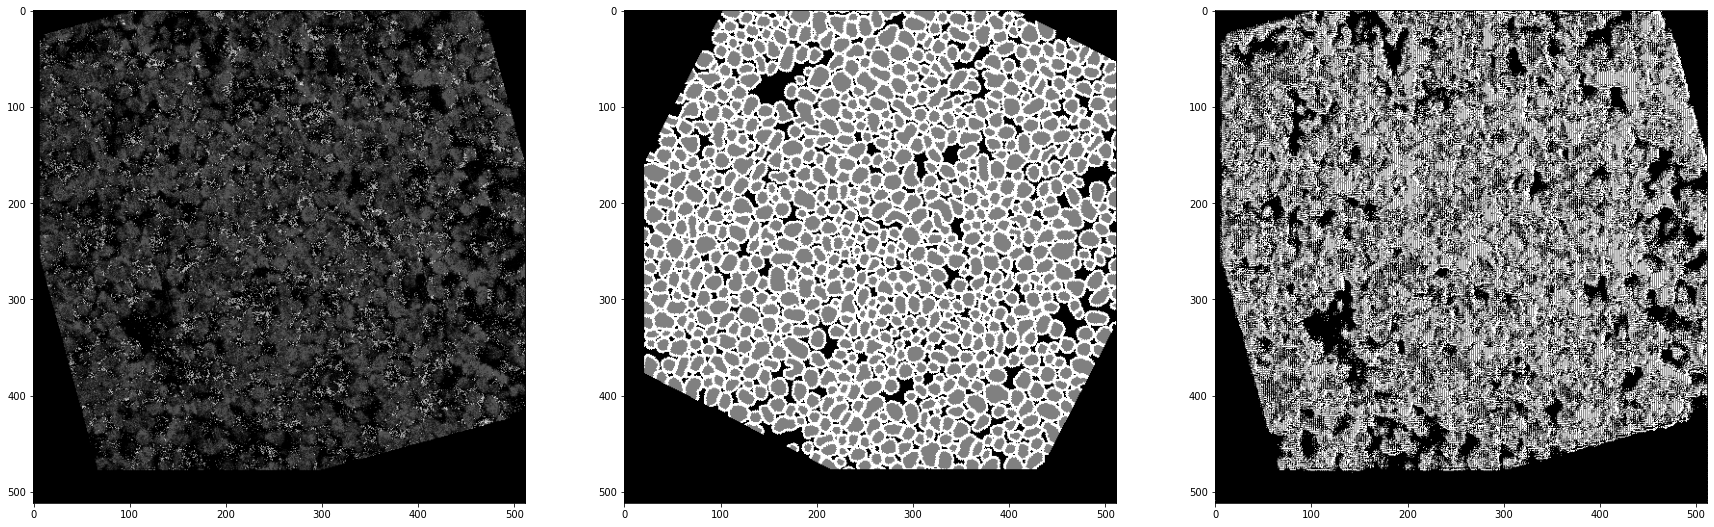

In [129]:
model.eval()
with torch.no_grad():
  output = model(img_to_predict.to(device))[0]
  pred_mask = torch.argmax(output, axis=0)
original_img = img_to_predict.numpy()
prediction_mask = pred_mask.cpu().numpy()
original_mask = mask_to_compare.numpy()

print(original_img[0][0].shape)
print(original_mask[0][0].shape)
print(prediction_mask.shape)



fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(30,10))


ax1.imshow(original_img[0][0],cmap="gray")
ax2.imshow(original_mask[0][0],cmap="gray")
ax3.imshow(prediction_mask,cmap="gray")
plt.show()

#### Training all the dataset

In [91]:
from tqdm import tqdm
def fit_model(model, dataloader_train,dataloader_valid, epochs=50, lr=1e-1):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  criterion = torch.nn.BCEWithLogitsLoss()
  model.to(device)
  hist = {'loss':[], 'iou': [], 'validation_loss':[], 'validation_iou':[]}
  for epoch in range(1, epochs+1):
    bar = tqdm(dataloader_train)
    train_loss, train_iou = [], []
    model.train()
    for imgs,masks in bar:
      imgs, masks = imgs.to(device), masks.to(device)
      optimizer.zero_grad()
      y_hat = model(imgs)
      loss = criterion(y_hat, masks)
      loss.backward()
      optimizer.step()
      ious = iou(y_hat, masks)
      #f1_loss = f1_score(y_hat,masks)
      train_loss.append(loss.item())
      train_iou.append(ious)
      #bar.set_description(f"loss {np.mean(train_loss):.5f} ==== iou {np.mean(train_iou):.5f} ==== F1 {np.mean(f1_loss):.5f}")
      bar.set_description(f"loss {np.mean(train_loss):.5f} ==== iou {np.mean(train_iou):.5f}.")
    hist['loss'].append(np.mean(train_loss))
    hist['iou'].append(np.mean(train_iou))
    bar = tqdm(dataloader_valid)
    valid_loss, valid_iou, F1_valid = [],[],[]
    model.eval()
    with torch.no_grad():
      for imgs, masks in bar:
        imgs, masks = imgs.to(device), masks.to(device)
        y_hat = model(imgs)
        loss = criterion(y_hat, masks)
        ious = iou(y_hat, masks)
        #f1_loss = f1_score(y_hat,masks)
        valid_loss.append(loss.item())
        valid_iou.append(ious)
        #F1_valid.append(f1_loss)
        #bar.set_description(f"validation_loss {np.mean(valid_loss):.5f} ==== validation_iou {np.mean(valid_iou):.5f} ==== validation_F1 {np.mean(f1_loss):.5f}")
        bar.set_description(f"validation_loss {np.mean(valid_loss):.5f} ==== validation_iou {np.mean(valid_iou):.5f}")
    hist['validation_loss'].append(np.mean(valid_loss))
    hist['validation_iou'].append(np.mean(valid_iou))
    print(f"\n->Epoch {epoch}/{epochs} -- loss {np.mean(train_loss):.5f} -- iou {np.mean(train_iou):.5f}")
  
  return hist

In [92]:
model1 = Unet_from_scratch()
device = "cuda" if torch.cuda.is_available() else "cpu"

history = fit_model(model1, dataloader_train, dataloader_valid, epochs=10 )

loss 0.03249 ==== iou 0.98016.: 100%|██████████| 50/50 [00:47<00:00,  1.05it/s]
validation_loss 0.02755 ==== validation_iou 1.00000: 100%|██████████| 13/13 [00:11<00:00,  1.10it/s]



->Epoch 1/10 -- loss 0.03249 -- iou 0.98016


loss 0.00943 ==== iou 1.00000.: 100%|██████████| 50/50 [00:47<00:00,  1.06it/s]
validation_loss 0.01215 ==== validation_iou 1.00000: 100%|██████████| 13/13 [00:11<00:00,  1.10it/s]



->Epoch 2/10 -- loss 0.00943 -- iou 1.00000


loss 0.00923 ==== iou 1.00000.: 100%|██████████| 50/50 [00:45<00:00,  1.09it/s]
validation_loss 0.00982 ==== validation_iou 1.00000: 100%|██████████| 13/13 [00:11<00:00,  1.10it/s]



->Epoch 3/10 -- loss 0.00923 -- iou 1.00000


loss 0.00922 ==== iou 1.00000.: 100%|██████████| 50/50 [00:47<00:00,  1.05it/s]
validation_loss 0.00997 ==== validation_iou 1.00000: 100%|██████████| 13/13 [00:11<00:00,  1.09it/s]



->Epoch 4/10 -- loss 0.00922 -- iou 1.00000


loss 0.00909 ==== iou 1.00000.: 100%|██████████| 50/50 [00:45<00:00,  1.10it/s]
validation_loss 0.00973 ==== validation_iou 1.00000: 100%|██████████| 13/13 [00:11<00:00,  1.10it/s]



->Epoch 5/10 -- loss 0.00909 -- iou 1.00000


loss 0.00908 ==== iou 1.00000.: 100%|██████████| 50/50 [00:47<00:00,  1.05it/s]
validation_loss 0.00979 ==== validation_iou 1.00000: 100%|██████████| 13/13 [00:11<00:00,  1.09it/s]



->Epoch 6/10 -- loss 0.00908 -- iou 1.00000


loss 0.00901 ==== iou 1.00000.: 100%|██████████| 50/50 [00:45<00:00,  1.09it/s]
validation_loss 0.00963 ==== validation_iou 1.00000: 100%|██████████| 13/13 [00:11<00:00,  1.10it/s]



->Epoch 7/10 -- loss 0.00901 -- iou 1.00000


loss 0.00907 ==== iou 1.00000.: 100%|██████████| 50/50 [00:47<00:00,  1.05it/s]
validation_loss 0.00956 ==== validation_iou 1.00000: 100%|██████████| 13/13 [00:11<00:00,  1.10it/s]



->Epoch 8/10 -- loss 0.00907 -- iou 1.00000


loss 0.00896 ==== iou 1.00000.: 100%|██████████| 50/50 [00:45<00:00,  1.10it/s]
validation_loss 0.00954 ==== validation_iou 1.00000: 100%|██████████| 13/13 [00:11<00:00,  1.10it/s]



->Epoch 9/10 -- loss 0.00896 -- iou 1.00000


loss 0.00903 ==== iou 1.00000.: 100%|██████████| 50/50 [00:46<00:00,  1.09it/s]
validation_loss 0.00955 ==== validation_iou 1.00000: 100%|██████████| 13/13 [00:11<00:00,  1.09it/s]


->Epoch 10/10 -- loss 0.00903 -- iou 1.00000


In [93]:
df = pd.DataFrame(history)
df.head()

loss       iou  validation_loss  validation_iou
0  0.032489  0.980159         0.027554             1.0
1  0.009426  1.000000         0.012148             1.0
2  0.009234  1.000000         0.009816             1.0
3  0.009217  1.000000         0.009972             1.0
4  0.009086  1.000000         0.009733             1.0

In [132]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter( y=df['loss'], name="loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=df['iou'], name="iou"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=df['validation_loss'], name="validation_loss"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter( y=df['validation_iou'], name="validation_iou"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="NeurIPS 2022 Segmentation metrics"
)

# Set x-axis title
fig.update_xaxes(title_text="Number of Epochs")

# Set y-axes titles
fig.update_yaxes(title_text="<b>%</b> Loss", secondary_y=False)
fig.update_yaxes(title_text="<b>%</b> Iou", secondary_y=True)

fig.show()

##### Transfer learning Unet architecture

In [38]:
from torchvision.models.resnet import conv3x3
import torch.nn.functional as F

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
  return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
    
    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x
import torchvision



class out_conv(torch.nn.Module):
  def __init__(self, ci, co, coo):
    super(out_conv, self).__init__()
    self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
    self.conv = conv3x3_bn(ci,co)
    self.final = torch.nn.Conv2d(co,coo, 1)
  
  def forward(self, x1, x2):
    x1 = self.upsample(x1)
    diffx = x2.size()[2] - x1.size()[2]
    diffy = x2.size()[3] - x1.size()[3]
    x1 = F.pad(x1, (diffx, 0, diffy,0))
    x = self.conv(x1)
    x = self.final(x)
    return x

class UNetResnet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=1):
        super().__init__()

        self.encoder = torchvision.models.resnet18(pretrained=True)
        if in_ch != 3:
          self.encoder.conv1 = torch.nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # capas del decoder
        self.deconv1 = deconv(512,256)
        self.deconv2 = deconv(256,128)
        self.deconv3 = deconv(128,64)

        # útlima capa conv que nos da la máscara
        self.out = out_conv(64,64,n_classes)

    def forward(self, x):
        # encoder
        x_in = torch.tensor(x.clone())
        x = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))
        x1 = self.encoder.layer1(x)
        x2 = self.encoder.layer2(x1)
        x3 = self.encoder.layer3(x2)
        x = self.encoder.layer4(x3)
        # decoder
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x,x_in)
        return x

In [39]:
model_TL = UNetResnet()
output = model_TL(torch.randn((10,1,394,394)))
output.shape

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

<ipython-input-38-0a36d9249b39>:75: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



torch.Size([10, 3, 394, 394])

In [40]:
model_TL = UNetResnet()
device = "cuda" if torch.cuda.is_available() else "cpu"
hist_tl = fit_model(model_TL, dataloader_train, dataloader_valid, epochs=10 )

  0%|          | 0/41 [00:00<?, ?it/s]<ipython-input-38-0a36d9249b39>:75: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

loss 0.04879 ==== iou 0.97561.: 100%|██████████| 41/41 [00:30<00:00,  1.33it/s]
validation_loss 0.03008 ==== validation_iou 1.00000: 100%|██████████| 22/22 [00:15<00:00,  1.40it/s]



->Epoch 1/10 -- loss 0.04879 -- iou 0.97561


loss 0.01183 ==== iou 1.00000.: 100%|██████████| 41/41 [00:29<00:00,  1.38it/s]
validation_loss 0.01126 ==== validation_iou 1.00000: 100%|██████████| 22/22 [00:15<00:00,  1.38it/s]



->Epoch 2/10 -- loss 0.01183 -- iou 1.00000


loss 0.01061 ==== iou 1.00000.: 100%|██████████| 41/41 [00:29<00:00,  1.37it/s]
validation_loss 0.01044 ==== validation_iou 1.00000: 100%|██████████| 22/22 [00:15<00:00,  1.38it/s]



->Epoch 3/10 -- loss 0.01061 -- iou 1.00000


loss 0.01034 ==== iou 1.00000.: 100%|██████████| 41/41 [00:30<00:00,  1.36it/s]
validation_loss 0.01024 ==== validation_iou 1.00000: 100%|██████████| 22/22 [00:15<00:00,  1.39it/s]



->Epoch 4/10 -- loss 0.01034 -- iou 1.00000


loss 0.01005 ==== iou 1.00000.: 100%|██████████| 41/41 [00:29<00:00,  1.39it/s]
validation_loss 0.01015 ==== validation_iou 1.00000: 100%|██████████| 22/22 [00:16<00:00,  1.37it/s]



->Epoch 5/10 -- loss 0.01005 -- iou 1.00000


loss 0.01017 ==== iou 1.00000.: 100%|██████████| 41/41 [00:31<00:00,  1.31it/s]
validation_loss 0.01049 ==== validation_iou 1.00000: 100%|██████████| 22/22 [00:15<00:00,  1.38it/s]



->Epoch 6/10 -- loss 0.01017 -- iou 1.00000


loss 0.00997 ==== iou 1.00000.: 100%|██████████| 41/41 [00:31<00:00,  1.32it/s]
validation_loss 0.01030 ==== validation_iou 1.00000: 100%|██████████| 22/22 [00:15<00:00,  1.38it/s]



->Epoch 7/10 -- loss 0.00997 -- iou 1.00000


loss 0.01009 ==== iou 1.00000.: 100%|██████████| 41/41 [00:31<00:00,  1.29it/s]
validation_loss 0.01046 ==== validation_iou 1.00000: 100%|██████████| 22/22 [00:15<00:00,  1.38it/s]



->Epoch 8/10 -- loss 0.01009 -- iou 1.00000


loss 0.00989 ==== iou 1.00000.: 100%|██████████| 41/41 [00:30<00:00,  1.33it/s]
validation_loss 0.01023 ==== validation_iou 1.00000: 100%|██████████| 22/22 [00:15<00:00,  1.38it/s]



->Epoch 9/10 -- loss 0.00989 -- iou 1.00000


loss 0.01006 ==== iou 1.00000.: 100%|██████████| 41/41 [00:30<00:00,  1.33it/s]
validation_loss 0.01001 ==== validation_iou 1.00000: 100%|██████████| 22/22 [00:15<00:00,  1.39it/s]


->Epoch 10/10 -- loss 0.01006 -- iou 1.00000


In [130]:
df_tl = pd.DataFrame(hist_tl)
df_tl.head()

loss      iou  validation_loss  validation_iou
0  0.048791  0.97561         0.030080             1.0
1  0.011835  1.00000         0.011261             1.0
2  0.010614  1.00000         0.010443             1.0
3  0.010336  1.00000         0.010240             1.0
4  0.010049  1.00000         0.010153             1.0

In [133]:

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter( y=df_tl['loss'], name="loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=df_tl['iou'], name="iou"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=df_tl['validation_loss'], name="validation_loss"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter( y=df_tl['validation_iou'], name="validation_iou"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="NeurIPS 2022 Segmentation metrics with transfer learning"
)

# Set x-axis title
fig.update_xaxes(title_text="Number of Epochs")

# Set y-axes titles
fig.update_yaxes(title_text="<b>%</b> Loss", secondary_y=False)
fig.update_yaxes(title_text="<b>%</b> Iou", secondary_y=True)

fig.show()